#### 作业五

1. 将dropout和ReLU应用于LeNet，效果有提升吗？再试试预处理会怎么样？

loss 0.459, train acc 0.829, test acc 0.821
4798.1 examples/sec on CPU


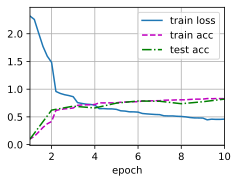

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from torchsummary import summary

# 定义LeNet模型
net = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

# 打印模型结构
summary(net, (1, 28, 28))

# 测试模型的前向传播
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

# 加载FashionMNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义在CPU上计算模型精度的函数
def evaluate_accuracy_cpu(net, data_iter):
    """使用CPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
    metric = d2l.Accumulator(2)  # 正确预测的数量，总预测的数量
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            metric.add(d2l.accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

# 定义训练函数
def train_ch6(net, train_iter, test_iter, num_epochs, lr):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', 'CPU')
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # 训练损失之和，训练准确率之和，样本数
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_cpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on CPU')

# 训练模型
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [ ]:
在LeNet中应用Dropout和ReLU激活函数

In [ ]:
import torch
from torch import nn
from torchvision import transforms
from d2l import torch as d2l
import matplotlib.pyplot as plt

# 定义带BN的LeNet
def lenet_bn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.ReLU(),
        nn.AvgPool2d(2, 2),
        nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.ReLU(),
        nn.AvgPool2d(2, 2), nn.Flatten(),
        nn.Linear(256, 120), nn.BatchNorm1d(120), nn.ReLU(),
        nn.Linear(120, 84), nn.BatchNorm1d(84), nn.ReLU(),
        nn.Linear(84, 10))
    # Kaiming初始化
    def init_weights(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    model.apply(init_weights)
    return model

# 定义不带BN的LeNet（保持其他结构相同）
def lenet_no_bn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5), nn.ReLU(),
        nn.AvgPool2d(2, 2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.AvgPool2d(2, 2), nn.Flatten(),
        nn.Linear(256, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))
    # 相同初始化
    def init_weights(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    model.apply(init_weights)
    return model

# 数据标准化（对不带BN的模型更重要）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 统一训练函数
def train_model(model, lr):
    device = d2l.try_gpu()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(10):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                metric.add(loss * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
                
        train_loss = metric[0]/metric[2]
        train_acc = metric[1]/metric[2]
        
    test_acc = d2l.evaluate_accuracy_gpu(model, test_iter)
    return test_acc

# 测试不同学习率
lr_list = [0.1, 0.03, 0.02,0.01, 0.003, 0.001,0.002,0.0002]
bn_acc = []
no_bn_acc = []

for lr in lr_list:
    # 训练带BN模型
    model_bn = lenet_bn()
    acc_bn = train_model(model_bn, lr)
    bn_acc.append(acc_bn)
    
    # 训练不带BN模型
    model_no_bn = lenet_no_bn()
    acc_no_bn = train_model(model_no_bn, lr)
    no_bn_acc.append(acc_no_bn)
    
    print(f'lr={lr:.0e}: BN={acc_bn:.3f}, NoBN={acc_no_bn:.3f}')

# 可视化对比
plt.figure(figsize=(10,6))
plt.semilogx(lr_list, bn_acc, 'o-', label='With BN')
plt.semilogx(lr_list, no_bn_acc, 's--', label='Without BN')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Test Accuracy')
plt.xticks(lr_list, [f'{lr:.0e}' for lr in lr_list])
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.title('BN vs NoBN Accuracy Comparison')
plt.show()

2. 比较LeNet在使用和不使用BN情况下的不同的学习率对测试准确度的影响。

loss 0.237, train acc 0.912, test acc 0.852
54996.1 examples/sec on cuda


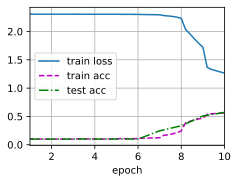

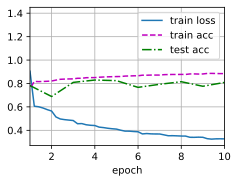

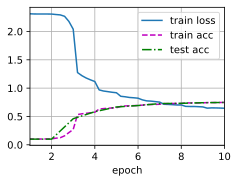

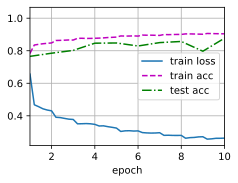

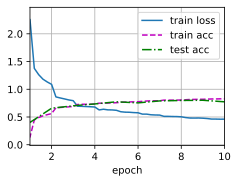

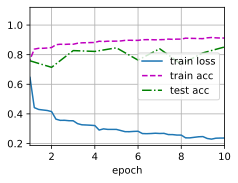

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from torchsummary import summary

# 定义原始LeNet模型（不使用BN）和使用BN的LeNet模型
def create_lenet(use_bn=False):
    if use_bn:
        return nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.BatchNorm2d(6),  # 添加BN
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.BatchNorm2d(16),  # 添加BN
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.BatchNorm1d(120),  # 添加BN
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),  # 添加BN
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

# 检测是否有可用的GPU，如果有则使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

# 打印模型结构
net_with_bn = create_lenet(use_bn=True).to(device)
net_without_bn = create_lenet(use_bn=False).to(device)

print("LeNet with BN:")
summary(net_with_bn, (1, 28, 28))

print("\nLeNet without BN:")
summary(net_without_bn, (1, 28, 28))

# 加载FashionMNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义在GPU上计算模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)  # 正确预测的数量，总预测的数量
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            metric.add(d2l.accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

# 定义训练函数
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # 训练损失之和，训练准确率之和，样本数
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter, device)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# 定义学习率列表
learning_rates = [0.1, 0.3, 0.9]
num_epochs = 10

# 训练两种模型
for lr in learning_rates:
    print(f"\nTraining LeNet without BN, learning rate: {lr}")
    train_ch6(net_without_bn, train_iter, test_iter, num_epochs, lr, device)

    print(f"\nTraining LeNet with BN, learning rate: {lr}")
    train_ch6(net_with_bn, train_iter, test_iter, num_epochs, lr, device)

3. 借助工具(如torchsummary)将AlexNet、VGG和NiN的模型参数大小与GoogLeNet进行比较。后两个网络架构是如何显著减少模型参数大小的？

In [11]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.nn import functional as F

# 定义AlexNet
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 定义VGG16
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 定义NiN
class NiN(nn.Module):
    def __init__(self, num_classes=1000):
        super(NiN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 160, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(160, 96, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.5),
            nn.Conv2d(96, 192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.5),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, num_classes, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        return self.features(x)

# 定义GoogLeNet（使用简化版）
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4):
        super(Inception, self).__init__()
        self.p1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2 = nn.Sequential(
            nn.Conv2d(in_channels, c2[0], kernel_size=1),
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        )
        self.p3 = nn.Sequential(
            nn.Conv2d(in_channels, c3[0], kernel_size=1),
            nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        )
        self.p4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, c4, kernel_size=1)
        )

    def forward(self, x):
        p1 = F.relu(self.p1(x))
        p2 = F.relu(self.p2(x))
        p3 = F.relu(self.p3(x))
        p4 = F.relu(self.p4(x))
        return torch.cat((p1, p2, p3, p4), dim=1)

class GoogleNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(GoogleNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            Inception(192, 64, (96, 128), (16, 32), 32),
            Inception(256, 128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            Inception(480, 192, (96, 208), (16, 48), 64),
            Inception(512, 160, (112, 224), (24, 64), 64),
            Inception(512, 128, (128, 256), (24, 64), 64),
            Inception(512, 112, (144, 288), (32, 64), 64),
            Inception(528, 256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            Inception(832, 256, (160, 320), (32, 128), 128),
            Inception(832, 384, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 统计参数量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_shape = (3, 224, 224)  # 假设输入为224x224的RGB图像

alexnet = AlexNet().to(device)
vgg = VGG16().to(device)
nin = NiN().to(device)
googlenet = GoogleNet().to(device)

print("AlexNet参数量：")
summary(alexnet, input_shape)

print("\nVGG16参数量：")
summary(vgg, input_shape)

print("\nNiN参数量：")
summary(nin, input_shape)

print("\nGoogLeNet参数量：")
summary(googlenet, input_shape)

AlexNet参数量：
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14       

4. 利用RseNet作为`作业四第2题`任务模型的的Backbone(骨干网络)，观察准确度是否有所提升。

c:\Users\sun\.conda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sun\.conda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\sun\AppData\Local\Temp\ipykernel_37900\702075272.py:77: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  running_loss += loss.item()


Epoch 1/10, Loss: 2.4595
Epoch 2/10, Loss: 2.2958
Epoch 3/10, Loss: 2.1796
Epoch 4/10, Loss: 2.0862
Epoch 5/10, Loss: 2.0395
Epoch 6/10, Loss: 1.9241
Epoch 7/10, Loss: 1.8597
Epoch 8/10, Loss: 1.7630
Epoch 9/10, Loss: 1.6735
Epoch 10/10, Loss: 1.5907


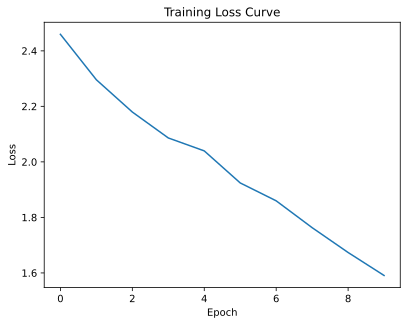

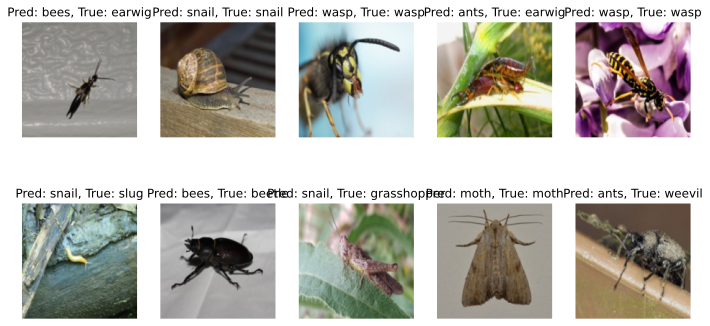

Accuracy of the network on the test images: 40.87325651910248%


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import random

# 设置随机数种子
torch.manual_seed(84)
np.random.seed(84)
random.seed(84)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(84)

# 1. 通过类继承的方式自定义一个卷积神经网络，使用ResNet作为骨干网络
class PestCNN(nn.Module):
    def __init__(self):
        super(PestCNN, self).__init__()
        # 使用ResNet18作为骨干网络
        self.resnet = models.resnet18(pretrained=False)
        # 修改最后一层全连接层的输出维度为12以匹配数据集中的类别数
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 12)

    def forward(self, x):
        return self.resnet(x)

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet输入尺寸为224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 数据集路径
data_path = "E:\study\AI\machine_study\deep_learning\work5\data"
# 检查路径是否存在
if not os.path.exists(data_path):
    print(f"错误：路径 {data_path} 不存在，请检查路径是否正确。")
else:
    # 加载数据集
    dataset = datasets.ImageFolder(root=data_path, transform=transform)

    # 2. 划分训练集和测试集，并构建训练数据和测试数据加载器
    train_size = int(0.7 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 3. 选取合适的损失函数和优化器
    model = PestCNN()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 4. 完成神经网络的训练,绘制训练loss曲线
    train_losses = []
    num_epochs = 10

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # 绘制训练 loss 曲线
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

    # 5. 给出一组测试结果的可视化样例
    model.eval()
    with torch.no_grad():
        dataiter = iter(test_loader)
        images, labels = next(dataiter)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        axes = axes.flatten()
        for i in range(10):
            img = images[i].cpu().numpy().transpose((1, 2, 0))
            img = img * 0.5 + 0.5  # 反归一化
            axes[i].imshow(np.clip(img, 0, 1))
            axes[i].set_title(f'Pred: {dataset.classes[predicted[i]]}, True: {dataset.classes[labels[i]]}')
            axes[i].axis('off')
        plt.show()

    # 6. 保存模型参数
    torch.save(model.state_dict(), 'pest_model.pth')

    # 7. 加载模型参数
    loaded_model = PestCNN()
    loaded_model.load_state_dict(torch.load('pest_model.pth'))
    loaded_model.to(device)
    loaded_model.eval()

    # 计算测试集上的准确率
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = loaded_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the test images: {100 * correct / total}%')